In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

In [2]:
transform = transforms.Compose([
    transforms.Resize((32,32), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [3]:
batch_size = 64

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle = False)

100%|██████████| 26421880/26421880 [00:01<00:00, 15294595.56it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299126.22it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5338608.75it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3869583.69it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def plot_sample_images(train_loader, class_names, num_samples=5):
    sample_batch, sample_labels = next(iter(train_loader))
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample_batch[i].squeeze().numpy(), cmap='gray')
        plt.title(f"{class_names[sample_labels[i]]}")
        plt.axis('off')
    plt.show()

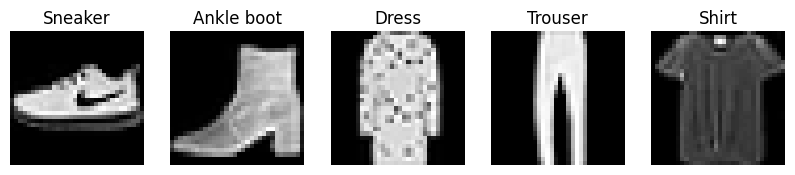

In [6]:
plot_sample_images(train_loader, train_dataset.classes)

In [21]:
latent_dim = 64

class AutoencoderFC(nn.Module):
    def __init__(self):
        super(AutoencoderFC, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1*32*32, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2)
        )

        # Xavier initialization for encoder
        for m in self.encoder.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

        self.mu = nn.Linear(16, latent_dim)
        self.log_var = nn.Linear(16, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1*32*32),
            nn.Tanh()
        )

        # Xavier initialization for decoder
        for m in self.decoder.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def reparameterize(self, mu, log_var):
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std


    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        x = self.decoder(z)
        x = nn.Unflatten(1, (1, 32, 32))(x)
        return x, mu, log_var


In [8]:
def square_mask(images, mask_size):

    batch_size, channels, height, width = images.size()
    mask = torch.zeros(batch_size, 1, height, width, dtype=torch.float32, device=images.device)

    max_top = height - mask_size - 1
    max_left = width - mask_size - 1

    top = np.random.randint(3, max_top, size=batch_size)
    left = np.random.randint(3, max_left, size=batch_size)

    for i in range(batch_size):
        mask[i, :, top[i]:top[i] + mask_size, left[i]:left[i] + mask_size] = 1

    return mask

In [9]:
def plot_masked_images(train_loader, mask_size, num_samples):
    sample_original, _ = next(iter(train_loader))
    sample_masked = sample_original.clone()
    mask = square_mask(sample_masked, mask_size)
    sample_masked[mask == 1] = 0
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(10, 10))

    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(sample_masked[i, 0], cmap='gray')
        ax.set_title('Masked')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

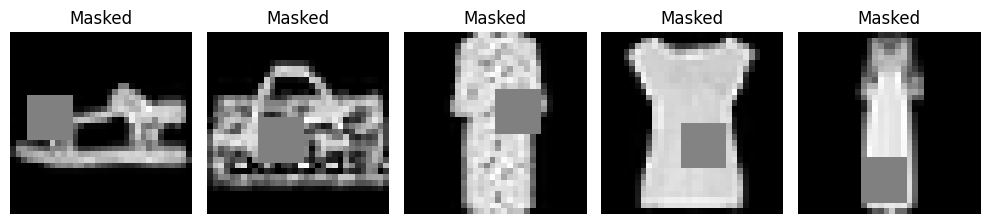

In [10]:
num_samples=5
mask_size=8
plot_masked_images(train_loader, mask_size, num_samples)

In [38]:
model = AutoencoderFC().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

def criterion_global(output, x, mu, log_var):
  loss = nn.MSELoss()
  loss_mse = loss(output, x)
  kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  total_loss = loss_mse + kl_loss
  return total_loss

def train_model(model, train_loader, optimizer, criterion_global, num_epochs, mask_size, device):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        running_loss_global = 0.0
        running_loss_local = 0.0
        for images, _ in train_loader:
            images = images.to(device)

            mask = square_mask(images, mask_size)
            masked_images = images.clone()
            masked_images[mask == 1] = 0

            outputs, mu, log_var  = model(masked_images)

            loss_global = criterion_global(outputs, images, mu, log_var)

            optimizer.zero_grad()

            loss_global.backward()
            optimizer.step()

            running_loss_global += loss_global.item()

        epoch_loss_global = running_loss_global / len(train_loader)
        train_losses.append(epoch_loss_global)
        print(f'Training Epoch [{epoch+1}/{num_epochs}], Global Loss: {epoch_loss_global:.4f}')

    return train_losses

In [39]:
train_losses = train_model(model, train_loader, optimizer, criterion_global, num_epochs, mask_size, device)

Training Epoch [1/10], Global Loss: 12.0040
Training Epoch [2/10], Global Loss: 0.5204
Training Epoch [3/10], Global Loss: 0.4431
Training Epoch [4/10], Global Loss: 0.3829
Training Epoch [5/10], Global Loss: 0.3576
Training Epoch [6/10], Global Loss: 0.3424
Training Epoch [7/10], Global Loss: 0.3349
Training Epoch [8/10], Global Loss: 0.3319
Training Epoch [9/10], Global Loss: 0.3304
Training Epoch [10/10], Global Loss: 0.3298


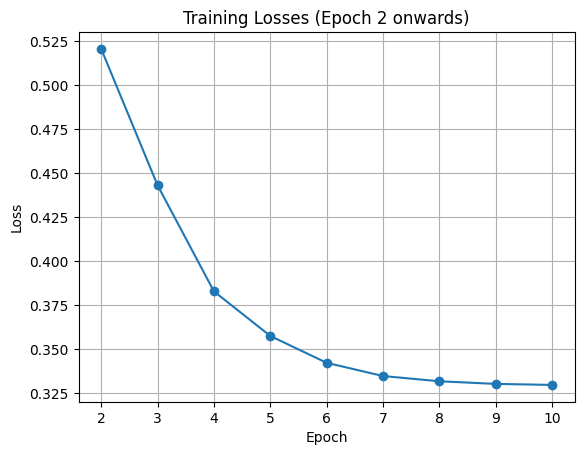

In [40]:
plt.plot(range(2, len(train_losses) + 1), train_losses[1:], marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses (Epoch 2 onwards)')
plt.grid(True)
plt.show()

In [34]:
def valid_model(model, valid_dataloader, criterion, device):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, _ in valid_dataloader:
            images = images.to(device)
            noisy_images = images + 0.1 * torch.randn_like(images)
            outputs, _, _ = model(noisy_images)
            valid_loss += criterion(outputs, images).item()

    average_valid_loss = valid_loss / len(valid_dataloader)
    print(f'Average Test Loss: {average_valid_loss:.4f}')
    return average_valid_loss

In [35]:
valid_loss = valid_model(model, valid_dataloader, criterion, device)

Average Test Loss: 0.3304


In [41]:
def visualize_inpainting(model, dataloader, mask_size):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(dataloader))  # Taking one batch from the dataloader
        masked_images = images.clone()
        mask = square_mask(images, mask_size)
        masked_images[mask == 1] = 0
        inpainted_images, _, _ = model(masked_images)

        # Extract masked region from original and reconstructed images
        reconstructed_masked_region = inpainted_images.clone()
        reconstructed_masked_region[mask == 0] = 0

    images = (images + 1) / 2  # Denormalize images
    reconstructed_masked_region = (reconstructed_masked_region + 1) / 2

    fig, axs = plt.subplots(4, 5, figsize=(15, 9))

    for i in range(5):

        axs[0, i].imshow(images[i].squeeze(), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title('Original Image')

        axs[1, i].imshow(masked_images[i].squeeze(), cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title('Masked Image')

        #axs[1, i].imshow(reconstructed_masked_region[i].squeeze(), cmap='gray')
        #axs[1, i].axis('off')
        #axs[1, i].set_title('Reconstructed Masked Region')
        axs[2, i].imshow(inpainted_images[i].squeeze(), cmap='gray')
        axs[2, i].axis('off')
        axs[2, i].set_title('Output')


        # Perform full reconstruction
        full_reconstructed_image = images.clone()
        full_reconstructed_image[i, 0, mask[i, 0] == 1] = reconstructed_masked_region[i, 0, mask[i, 0] == 1]

        axs[3, i].imshow(full_reconstructed_image[i].squeeze(), cmap='gray')
        axs[3, i].axis('off')
        axs[3, i].set_title('Full Reconstructed Image')


    plt.tight_layout()
    plt.show()

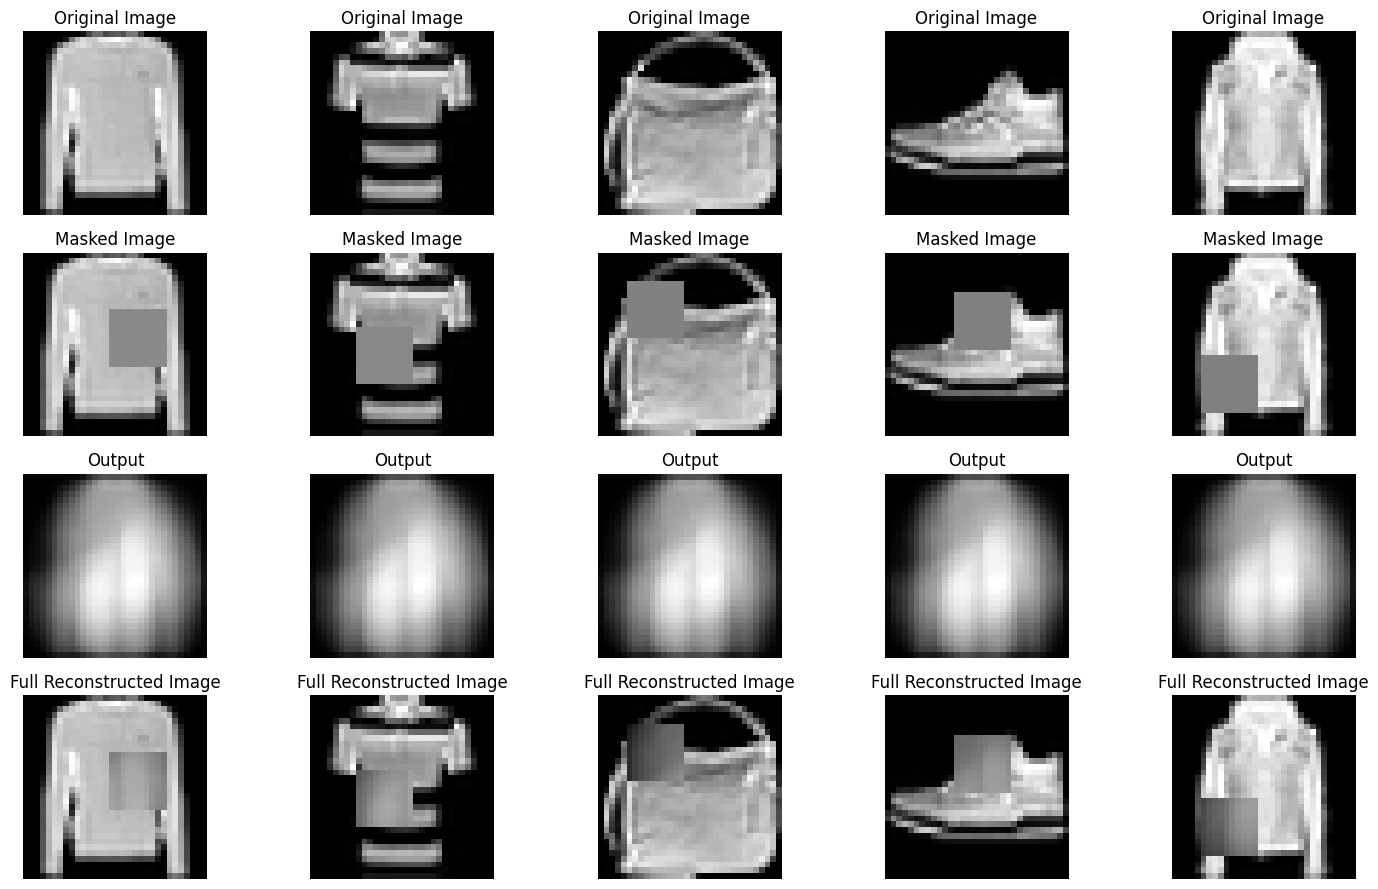

In [42]:
visualize_inpainting(model, train_loader, mask_size=10)